In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv('Dataset/crypto_monthly.csv') 
df.head()

,Date,Open_Price,Close_Price,High_Price,Low_Price,Volume,RSI,Volatility,Global_Economy,Sentiment_Score,Event_Impact,MA_5,MA_10,Price_Change,Price_Movement
0,2023-10-31,57397.216577,48824.312969,57411.578393,30541.786398,164421430,49.637677,0.029853,0.580645,0.063855,0.050326,50612.089545,47991.859734,-8572.903608,0
1,2023-11-30,51782.740012,33747.230312,60069.188441,29977.796001,185657473,45.759111,0.039044,0.533333,0.182264,0.045588,49290.616691,46529.061480,-18035.509700,0
2,2023-12-31,31380.079261,58245.585090,58945.959817,30249.517162,171450601,48.522087,0.048923,0.483871,0.064615,0.039810,50870.775888,49225.015011,26865.505829,1
3,2024-01-31,41583.079134,57745.278803,60388.438312,30052.887555,174184771,48.930698,0.013260,0.483871,0.061566,0.051840,50911.340042,50546.430321,16162.199669,1
4,2024-02-29,55752.382555,31995.906859,59206.502071,29863.830293,157162993,49.878218,0.024224,0.724138,0.196273,0.049517,46111.662807,49156.465648,-23756.475696,0


In [37]:
df.dtypes

Date                object
Open_Price         float64
Close_Price        float64
High_Price         float64
Low_Price          float64
Volume               int64
RSI                float64
Volatility         float64
Global_Economy     float64
Sentiment_Score    float64
Event_Impact       float64
MA_5               float64
MA_10              float64
Price_Change       float64
Price_Movement       int64
dtype: object

In [38]:
#Convert date to type datetime
df['Date'] = pd.to_datetime(df['Date'])

#drop Price_Change and Close_Price
df.drop(['Price_Change', 'Close_Price'], axis=1, inplace=True)

#drop null
df.dropna(inplace=True)

print(df.dtypes)

Date               datetime64[ns]
Open_Price                float64
High_Price                float64
Low_Price                 float64
Volume                      int64
RSI                       float64
Volatility                float64
Global_Economy            float64
Sentiment_Score           float64
Event_Impact              float64
MA_5                      float64
MA_10                     float64
Price_Movement              int64
dtype: object


In [39]:
# Exclude non-feature columns from scaling
cols_to_scale = df.columns.difference(['Date', 'Price_Movement'])

# Scale the features
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[cols_to_scale])

# Create dataframe with scaled features
features_scaled_df = pd.DataFrame(scaled_values, columns=cols_to_scale, index=df.index)

# Add the target column back without scaling
features_scaled_df['Price_Movement'] = df['Price_Movement']
features_scaled_df['Date'] = df['Date']

print(features_scaled_df.head())

   Event_Impact  Global_Economy  High_Price  Low_Price     MA_10      MA_5  \
0      0.050603        0.857464   -2.259642   0.164044  1.229011  1.557150   
1     -0.848521        0.343342    0.463375  -0.409923  0.674182  1.206650   
2     -1.945250       -0.194149   -0.687497  -0.133395  1.696738  1.625763   
3      0.338001       -0.194149    0.790482  -0.333503  2.197941  1.636522   
4     -0.102843        2.416752   -0.420543  -0.525905  1.670738  0.363483   

   Open_Price       RSI  Sentiment_Score  Volatility    Volume  \
0    1.418835 -0.192801         0.608173   -0.018779 -0.197715   
1    0.779749 -2.041172         1.720789    0.786756  1.271124   
2   -1.542648 -0.724447         0.615317    1.652625  0.288473   
3   -0.381260 -0.529719         0.586669   -1.473129  0.477588   
4    1.231606 -0.078169         1.852418   -0.512173 -0.699761   

   Price_Movement       Date  
0               0 2023-10-31  
1               0 2023-11-30  
2               1 2023-12-31  
3         

In [40]:
# Define the window size
window_size = 10

def create_time_windows(data, window_size):
    X_windows = []
    y_windows = []
    
    # Loop starting from window_size to the end of data rows
    for i in range(window_size, len(data)):
        # Get window of features for the previous window_size days
        X_window = data.iloc[i-window_size:i].values
        # Get the target for the current day (could be adjusted as needed)
        y_window = features_scaled_df.iloc[i]['Price_Movement']
        X_windows.append(X_window)
        y_windows.append(y_window)
    
    return np.array(X_windows), np.array(y_windows)

# Prepare features (drop Date and Price_Movement columns)
features = features_scaled_df.drop(['Date', 'Price_Movement'], axis=1)

# Create the windows
X_seq, y_seq = create_time_windows(features, window_size)

# Check the shapes. X_seq should have shape (samples, 30, num_features)
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (1624, 10, 11)
y_seq shape: (1624,)


In [41]:
def create_train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):

    n = len(X)
    
    # Calculate the split indices
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    # Split the data
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Create the splits with default 70-15-15 ratio
X_train, y_train, X_val, y_val, X_test, y_test = create_train_val_test_split(X_seq, y_seq)

# Print the shapes to verify
print(f"Training set: X shape = {X_train.shape}, y shape = {y_train.shape}")
print(f"Validation set: X shape = {X_val.shape}, y shape = {y_val.shape}")
print(f"Test set: X shape = {X_test.shape}, y shape = {y_test.shape}")

Training set: X shape = (1136, 10, 11), y shape = (1136,)
Validation set: X shape = (243, 10, 11), y shape = (243,)
Test set: X shape = (245, 10, 11), y shape = (245,)


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Combine train and validation data for cross-validation
# Assuming X_train, y_train, X_val, y_val are already defined
X_combined = np.concatenate([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val], axis=0)

# Get shapes for model creation
_, timesteps, n_features = X_combined.shape

# Define the model creation function (modified with more LSTM and Dense layers)
def create_lstm_model(timesteps, n_features):
    model = Sequential()
    # First LSTM layer with output sequences
    model.add(LSTM(128, input_shape=(timesteps, n_features), return_sequences=True))
    model.add(Dropout(0.2))
    
    # Second LSTM layer with output sequences
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))

    # Third LSTM layer without returning sequences
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    
    # Additional Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Set up K-fold cross-validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store metrics
fold_train_losses = []
fold_val_losses = []
fold_train_accs = []
fold_val_accs = []
all_conf_matrices = []
histories = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_combined)):
    print(f"\nFold {fold+1}/{n_folds}")
    
    # Split data for this fold
    X_train_fold, X_val_fold = X_combined[train_idx], X_combined[val_idx]
    y_train_fold, y_val_fold = y_combined[train_idx], y_combined[val_idx]
    
    # Create a fresh model for each fold
    model = create_lstm_model(timesteps, n_features)
    
    # Set up callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(f'best_lstm_model_fold_{fold+1}.h5', save_best_only=True, monitor='val_loss')
    ]
    
    # Train the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=10,
        batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=1
    )
    
    # Store training history
    histories.append(history)
    
    # Evaluate on training and validation data
    train_loss, train_acc = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    
    # Store metrics
    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)
    
    # Calculate predictions and confusion matrix
    y_pred = (model.predict(X_val_fold) > 0.5).astype(int).flatten()
    all_conf_matrices.append(confusion_matrix(y_val_fold, y_pred))
    
    print(f"Fold {fold+1} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    print(classification_report(y_val_fold, y_pred))


Fold 1/5
Epoch 1/10
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5064 - loss: 0.6936

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5033 - loss: 0.6937 - val_accuracy: 0.4928 - val_loss: 0.6939
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5465 - loss: 0.6901 - val_accuracy: 0.4674 - val_loss: 0.6967
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5398 - loss: 0.6903 - val_accuracy: 0.4601 - val_loss: 0.7011
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5568 - loss: 0.6826 - val_accuracy: 0.4710 - val_loss: 0.7069
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5707 - loss: 0.6782 - val_accuracy: 0.4855 - val_loss: 0.7003
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5704 - loss: 0.6790 - val_accuracy: 0.4710 - val_loss: 0.7108
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Fold 1 - Train Acc: 0.5521, Val Acc: 0.4928
              precision    recall  f1-score   support

           0       0.53      0.30      0.39       145
           1       0.48      0.70      0.57       131

   

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5077 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 2/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5575 - loss: 0.6891

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5547 - loss: 0.6893 - val_accuracy: 0.5181 - val_loss: 0.6910
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5460 - loss: 0.6874 - val_accuracy: 0.5145 - val_loss: 0.6963
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5393 - loss: 0.6864 - val_accuracy: 0.5217 - val_loss: 0.6928
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5765 - loss: 0.6755 - val_accuracy: 0.5471 - val_loss: 0.6915
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5679 - loss: 0.6737 - val_accuracy: 0.5072 - val_loss: 0.7049
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5627 - loss: 0.6717 - val_accuracy: 0.5181 - val_loss: 0.6991
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fold 2 - Train Acc: 0.5567, Val Acc: 0.5181
              precision    recall  f1-score   support

           0       0.52      0.28      0.36       136
           1       0.52      0.75      0.61       140

   

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4930 - loss: 0.6935 - val_accuracy: 0.4964 - val_loss: 0.6947
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5456 - loss: 0.6908 - val_accuracy: 0.4783 - val_loss: 0.6974
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5440 - loss: 0.6884 - val_accuracy: 0.4891 - val_loss: 0.6982
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5592 - loss: 0.6869 - val_accuracy: 0.5217 - val_loss: 0.6950
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5370 - loss: 0.6883 - val_accuracy: 0.5326 - val_loss: 0.6965
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5928 - loss: 0.6778 - val_accuracy: 0.5145 - val_loss: 0.6996
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fold 3 - Train Acc: 0.5286, Val Acc: 0.4964
              precision    recall  f1-score   support

           0       0.47      0.69      0.56       128
           1       0.55      0.33      0.41       148

   

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4517 - loss: 0.6942 - val_accuracy: 0.5254 - val_loss: 0.6927
Epoch 2/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5176 - loss: 0.6926

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5182 - loss: 0.6926 - val_accuracy: 0.5326 - val_loss: 0.6905
Epoch 3/10
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5254 - loss: 0.6925

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5250 - loss: 0.6923 - val_accuracy: 0.5217 - val_loss: 0.6892
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5715 - loss: 0.6834 - val_accuracy: 0.5036 - val_loss: 0.6926
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5559 - loss: 0.6830 - val_accuracy: 0.5217 - val_loss: 0.6929
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5838 - loss: 0.6712 - val_accuracy: 0.5362 - val_loss: 0.6920
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5750 - loss: 0.6731 - val_accuracy: 0.5217 - val_loss: 0.6910
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5543 - loss: 0.6755 - val_accuracy: 0.5145 - val_loss: 0.6942
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fold 4 - Train Acc: 0.5530, Val Acc: 0.5217
              precision    recall  f1-score   support

           0       0.53      0.44      0.48       138
           1       0.52      0.60      0.56       138

   

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4952 - loss: 0.6933 - val_accuracy: 0.5273 - val_loss: 0.6921
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5369 - loss: 0.6898 - val_accuracy: 0.5055 - val_loss: 0.6959
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5784 - loss: 0.6827 - val_accuracy: 0.4836 - val_loss: 0.6987
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5608 - loss: 0.6820 - val_accuracy: 0.4655 - val_loss: 0.7033
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5861 - loss: 0.6731 - val_accuracy: 0.4618 - val_loss: 0.7063
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5800 - loss: 0.6669 - val_accuracy: 0.4800 - val_loss: 0.7247
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fold 5 - Train Acc: 0.5553, Val Acc: 0.5273
              precision    recall  f1-score   support

           0       0.53      0.42      0.47       137
           1       0.52      0.63      0.57       138

   


==== Cross-Validation Results ====
Average Training Accuracy: 0.5491 ± 0.0104
Average Validation Accuracy: 0.5113 ± 0.0140
Average Training Loss: 0.6890 ± 0.0022
Average Validation Loss: 0.6922 ± 0.0020


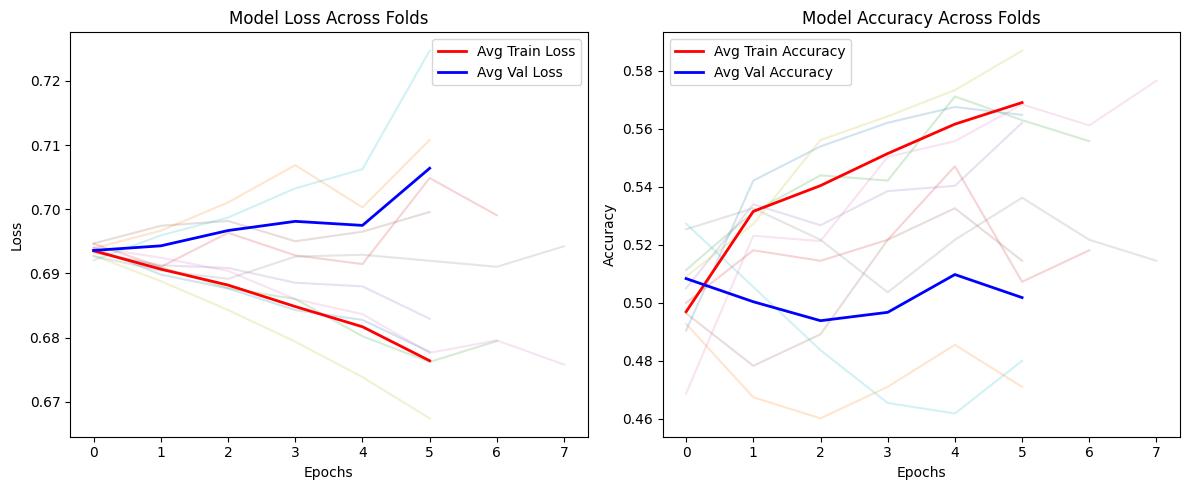

In [43]:
# Print average results
print("\n==== Cross-Validation Results ====")
print(f"Average Training Accuracy: {np.mean(fold_train_accs):.4f} ± {np.std(fold_train_accs):.4f}")
print(f"Average Validation Accuracy: {np.mean(fold_val_accs):.4f} ± {np.std(fold_val_accs):.4f}")
print(f"Average Training Loss: {np.mean(fold_train_losses):.4f} ± {np.std(fold_train_losses):.4f}")
print(f"Average Validation Loss: {np.mean(fold_val_losses):.4f} ± {np.std(fold_val_losses):.4f}")

# Plot average learning curves
plt.figure(figsize=(12, 5))


if histories:
    # Plot average loss
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], alpha=0.2)
        plt.plot(history.history['val_loss'], alpha=0.2)

    min_epochs = min(len(history.history['loss']) for history in histories)
    avg_train_loss = np.mean([history.history['loss'][:min_epochs] for history in histories], axis=0)
    avg_val_loss = np.mean([history.history['val_loss'][:min_epochs] for history in histories], axis=0)
    plt.plot(avg_train_loss, 'r-', linewidth=2, label='Avg Train Loss')
    plt.plot(avg_val_loss, 'b-', linewidth=2, label='Avg Val Loss')
    plt.title('Model Loss Across Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # Plot average accuracy
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], alpha=0.2)
        plt.plot(history.history['val_accuracy'], alpha=0.2)

    min_epochs_acc = min(len(history.history['accuracy']) for history in histories)
    avg_train_acc = np.mean([history.history['accuracy'][:min_epochs_acc] for history in histories], axis=0)
    avg_val_acc = np.mean([history.history['val_accuracy'][:min_epochs_acc] for history in histories], axis=0)
    plt.plot(avg_train_acc, 'r-', linewidth=2, label='Avg Train Accuracy')
    plt.plot(avg_val_acc, 'b-', linewidth=2, label='Avg Val Accuracy')
    plt.title('Model Accuracy Across Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No training history available. Skipping learning curves plot.")

In [44]:
# Merge the training and validation sets
X_final = np.concatenate([X_train, X_val], axis=0)
y_final = np.concatenate([y_train, y_val], axis=0)

# Create and train the final model
final_model = create_lstm_model(timesteps, n_features)
callbacks_final = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

#Save final model
final_model.save('models/prediction_yearly.keras')

history_final = final_model.fit(
    X_final,
    y_final,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks_final,
    verbose=1
)

# Evaluate the model on the test set and make predictions
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=1)
y_test_pred = (final_model.predict(X_test) > 0.5).astype(int).flatten()

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5150 - loss: 0.6935 - val_accuracy: 0.5362 - val_loss: 0.6929
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5491 - loss: 0.6891 - val_accuracy: 0.5580 - val_loss: 0.6934
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5489 - loss: 0.6857 - val_accuracy: 0.5217 - val_loss: 0.7009
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5775 - loss: 0.6757 - val_accuracy: 0.5145 - val_loss: 0.6975
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5785 - loss: 0.6750 - val_accuracy: 0.5000 - val_loss: 0.7116
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5626 - loss: 0.6683 - val_accuracy: 0.4710 - val_loss: 0.7121
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5444 - loss: 0.6906 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Loss: 0.6941019892692566
Test Accuracy: 0.5265306234359741
Confusion Matrix:
[[ 13 106]
 [ 10 116]]
Classification Report:
